In [6]:
# Spectacle
from spectacle.core.spectra import Spectrum1D
from spectacle.modeling.models import Absorption1D
from spectacle.core.lines import Line
from spectacle.modeling.fitting import LevMarFitter, LevMarLSQFitter, DynamicLevMarFitter

# Misty
import os, sys
sys.path.insert(0, "/Users/nearl/projects/enzo_specs/")
import MISTY

# yt/enzo
import trident
import yt

# general
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

# Trident setup

In [7]:
# Load trident ray data using yt
# tri_ray = yt.load("/Users/nearl/Downloads/RD0042_ray_z_imp022.9_ang5.32_tri.h5")
tri_ray = yt.load("/Users/nearl/Downloads/RD0042_ray_z_imp020.0_ang0.00tri.h5")

# Parse the start/end of ray
ray_start = tri_ray.light_ray_solution[0]['start']
ray_end = tri_ray.light_ray_solution[0]['end']

# Get line information for the line we want
line_name = "Si II 1260"
ldb = trident.LineDatabase('lines.txt')
line_out = ldb.parse_subset(line_name)
line_out = line_out[0]
ar = tri_ray.all_data()

print(line_name, line_out)

# Parse spectrum information from ray
lambda_rest = line_out.wavelength
lambda_min = lambda_rest * (1+min(ar['redshift_eff'])) - 7
lambda_max = lambda_rest * (1+max(ar['redshift_eff'])) + 7
sg = trident.SpectrumGenerator(lambda_min=lambda_min.value, lambda_max=lambda_max.value, dlambda=0.0001)
sg.make_spectrum(tri_ray, lines=line_out.name)

yt : [INFO     ] 2017-05-31 13:31:18,921 Parameters: current_time              = 4.343065399597899e+17 s
yt : [INFO     ] 2017-05-31 13:31:18,922 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-05-31 13:31:18,923 Parameters: domain_left_edge          = [ 0.  0.  0.] cm
yt : [INFO     ] 2017-05-31 13:31:18,924 Parameters: domain_right_edge         = [  4.43982386e+26   4.43982386e+26   4.43982386e+26] cm
yt : [INFO     ] 2017-05-31 13:31:18,925 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-05-31 13:31:18,925 Parameters: current_redshift          = 4.4408920985e-16
yt : [INFO     ] 2017-05-31 13:31:18,926 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2017-05-31 13:31:18,927 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2017-05-31 13:31:18,927 Parameters: hubble_constant           = 0.695
yt : [INFO     ] 2017-05-31 13:31:19,026 Allocating for 1.530e+02 particles (index particle type 'all')
yt : [INFO     ] 2017-05-

Si II 1260 Si II 1260


yt : [INFO     ] 2017-05-31 13:31:19,256 Setting instrument to Custom
yt : [INFO     ] 2017-05-31 13:31:19,263 Creating Si_p1_number_density from ray's density, temperature, metallicity.
/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/trident/ion_balance.py:378: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  force_override=force_override)
/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/trident/ion_balance.py:388: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  force_override=force_override)
/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/trident/ion_balance.py:410: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  particle_type=particle_type, force_override=force_override)
/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/trident/ion_balance.py:529: UserWarning: Because 'sampling_type' not sp

# Spectacle setup

In [8]:
# Create Spectrum1D from trident information
disp = np.array(list(sg.lambda_field))
flux = np.array(list(sg.flux_field))
spectrum = Spectrum1D(flux, dispersion=disp)

<IPython.core.display.Javascript object>


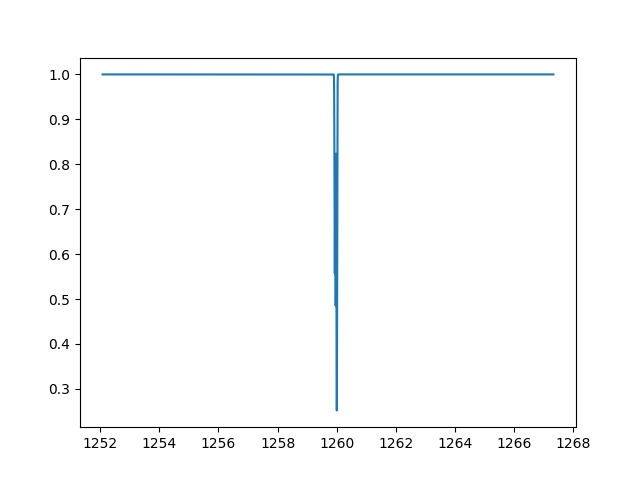

In [9]:
# Plot the trident spectrum
f, ax1 = plt.subplots()

ax1.plot(disp, flux)

In [17]:
# Create Line1D from trident line information
# Loop over the trident line list and add each defined line to
# the absorption profile model
sg_line = sg.line_list[0]

# This process will find lines in the trident spectrum
# and assign the values set in the `defaults` dict to
# the new lines found.
lines = spectrum.find_lines(threshold=0.000005,
                            min_dist=1,
                            smooth=False,
                            interpolate=True,
                            defaults=dict(
                                f_value=sg_line['f_value'],
                                gamma=sg_line['gamma'],
                                column_density=12,
                                fixed={'delta_v': False,
                                       'delta_lambda': False}
                           ))

# Create absorption Spectrum1D from line information
spec_mod = Absorption1D(lines=lines)

# Create a Spectrum1D object from the Absorption1D model
gen_spec = spec_mod(spectrum.dispersion)

INFO:root:Found 3 lines.
INFO:root:Found SII1260 (1259.519) at 1259.9323758153994. Strict is False.
INFO:root:Found SII1260_1 (1259.519) at 1259.9621760005584. Strict is False.
INFO:root:Found SiII1260 (1260.4221) at 1259.9997762341816. Strict is False.
INFO:root:There are 3 lines in the model.


<IPython.core.display.Javascript object>


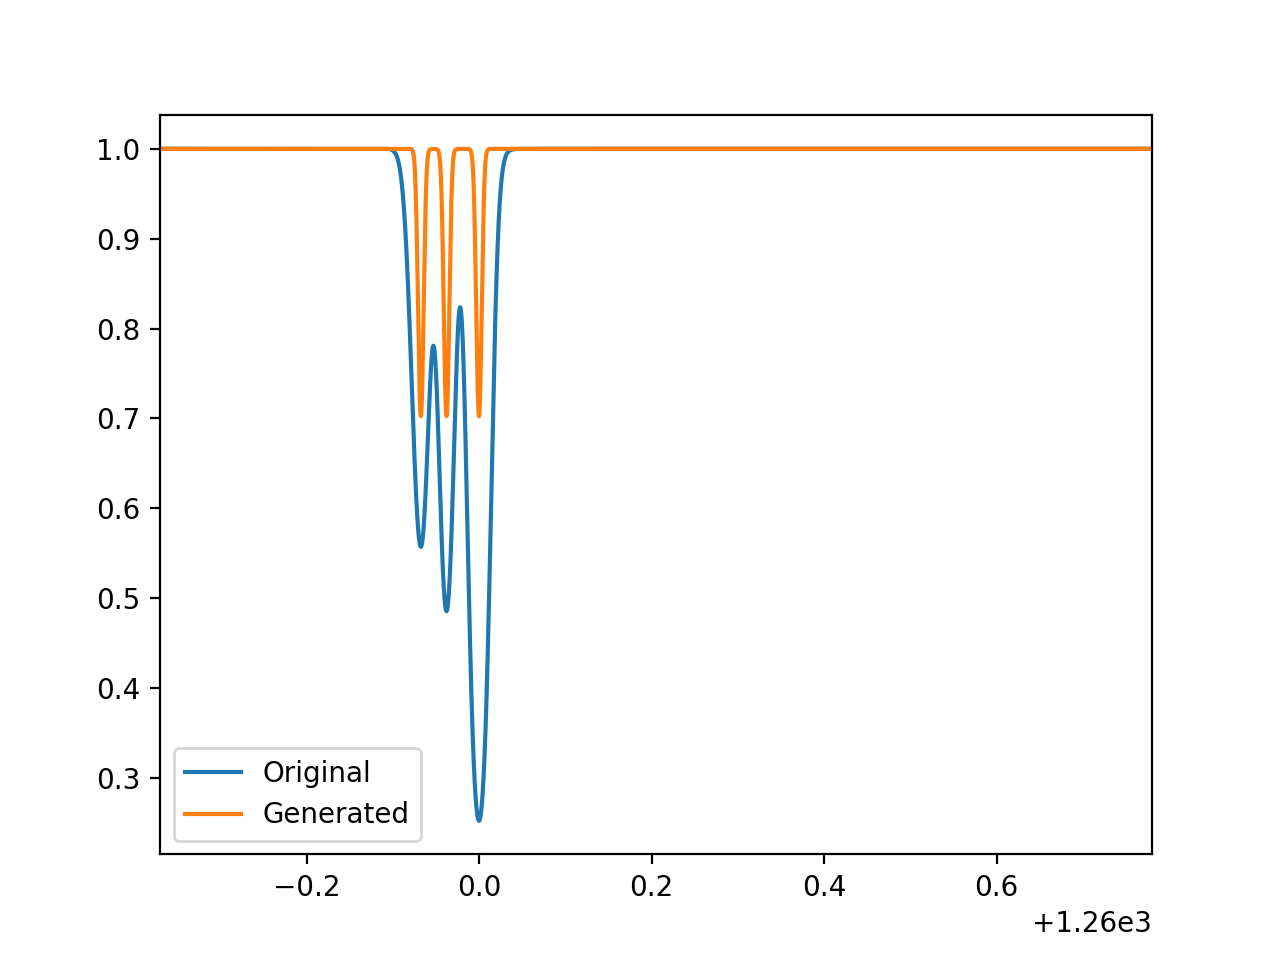

In [18]:
# Plot the generated absorption spectrum
f, ax = plt.subplots()

ax.plot(spectrum.dispersion, spectrum.data, label="Original")
ax.plot(spectrum.dispersion, gen_spec.data, label="Generated")
ax.set_xlim(1259.63, 1260.78)

plt.legend(loc=0)

In [19]:
# Now fit the generated Spectrum1D object to the ray spectrum data

# Create a fitter
fitter = LevMarFitter()

fit_spec_mod = fitter(spec_mod, spectrum.dispersion, spectrum.data, 
                      maxiter=1000, initialize=False)

# Get the results of the fit
fit_spec = fit_spec_mod(spectrum.dispersion)

/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/astropy/units/quantity.py:966: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/astropy/units/quantity.py:983: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)
/Users/nearl/projects/spectacle/spectacle/core/profiles.py:90: RuntimeWarning: invalid value encountered in multiply
  return special.wofz(x + 1j * y).real
/Users/nearl/projects/spectacle/spectacle/core/spectra.py:119: RuntimeWarning: invalid value encountered in less
  data[data < 0.0] = 0.0


<IPython.core.display.Javascript object>


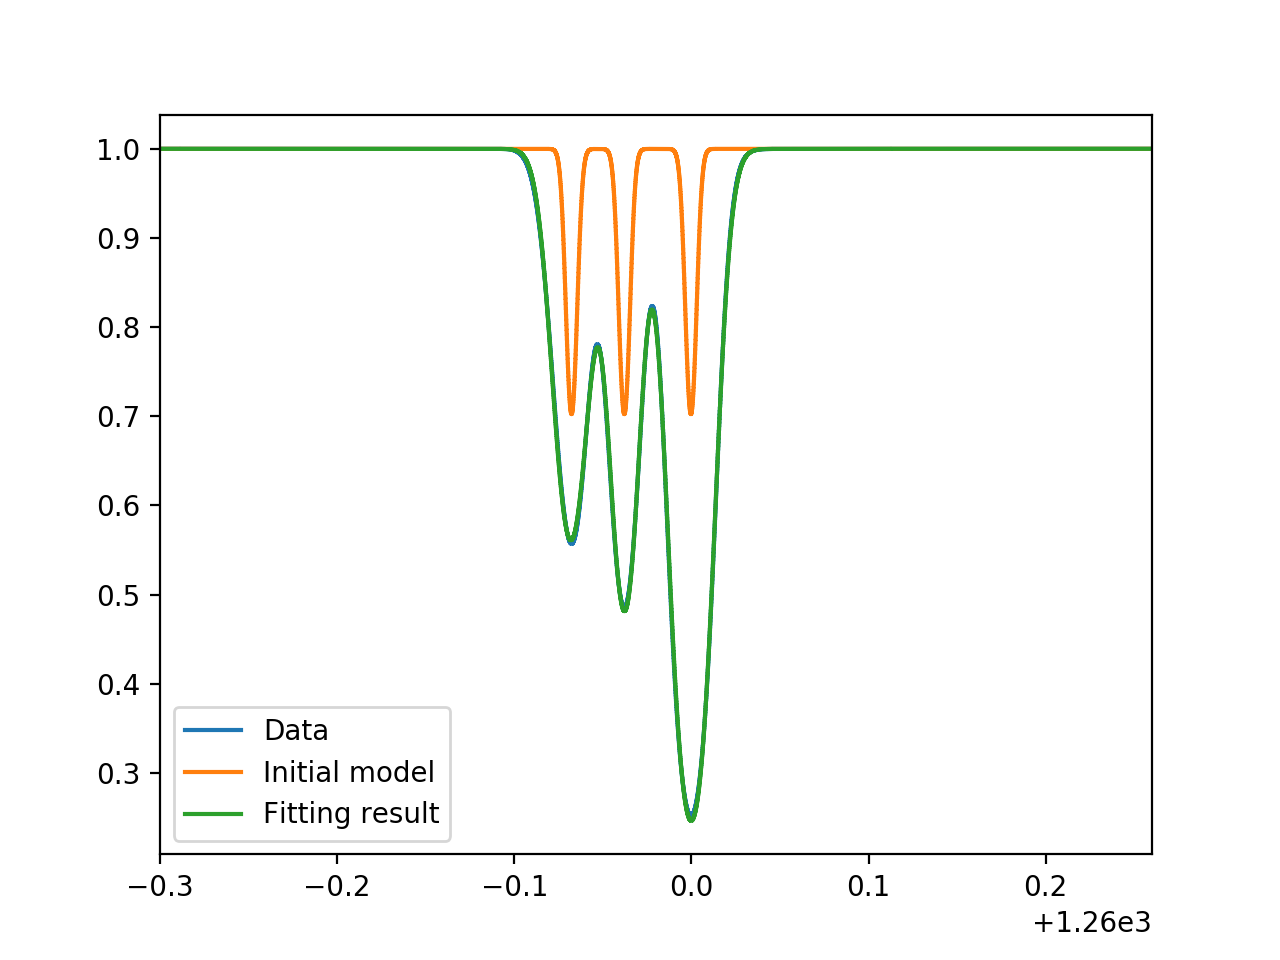

In [20]:
# Plot the stacked results
f, (ax1) = plt.subplots()

ax1.step(spectrum.dispersion, spectrum.data, label="Data")
ax1.step(gen_spec.dispersion, gen_spec.data, label="Initial model")
ax1.step(fit_spec.dispersion, fit_spec.data, label="Fitting result")
ax1.set_xlim(1259.7, 1260.26)

plt.legend(loc=0)

In [14]:
# Check out the results
print(fit_spec_mod)
[print(x.v_doppler, x.column_density) for x in fit_spec_mod[1:]]
print(fit_spec_mod[2].fixed)

Model: Absorption1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Linear1D(slope=0.0, intercept=1.0)>

    [1]: <Line(lambda_0=1259.9323758153994, f_value=0.188, gamma=403000000.0, v_doppler=100000.0, column_density=13.0, delta_v=0.0, delta_lambda=0.0, name='SII1260')>

    [2]: <Line(lambda_0=1259.9621760005584, f_value=0.188, gamma=403000000.0, v_doppler=100000.0, column_density=13.0, delta_v=0.0, delta_lambda=0.0, name='SII1260_1')>

    [3]: <Line(lambda_0=1259.9997762341816, f_value=0.188, gamma=403000000.0, v_doppler=100000.0, column_density=13.0, delta_v=0.0, delta_lambda=0.0, name='SiII1260')>
Parameters:
         slope_0        intercept_0   ...   delta_v_3     delta_lambda_3 
    ------------------ -------------- ... ------------- -----------------
    -2.61902488068e-08 0.999967015961 ... 4.83705888335 2.45320916714e-06
Parameter('v_doppler', value=96241.08904475752, bounds=(0, 1e+20)) Parameter('column_density', va